# Analysis of StackOverflow Survey. Part IV 

In this notebook we build a predictiv model for job satisfaction. 

In [1]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

In [2]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

## State the question
I am addressing the third question in this notebook. What can we tell about the job satisfaction of a data coder? What factors do influence it? Also, predict the job satisfaction for a developer who works with big data. 

This is a classification question, we are predicting a satisfaction level for a data developer, which includes: data scientist or machine learning specialist, data or business analyst and data engineer.

## Performance metrics - to review at the end

The following performance measures will be used in this project:
1. Cross validation via StratifiedKFold with 10 folds.
2. Confusion matrix, in particular precision, recall and F1 score.
3. The ROC curve and the related AUC score.

## Gather the data

Upload the data and keep the subset that contains those developers that work in data science related fields.

In [20]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')

# check the uploaded data
df1.shape

(64461, 25)

In [21]:
# the data frame that contains the data developers only
df1 = df1[df1.DevClass == 'data_coder']

# check the size of the data
df1.shape

(8726, 25)

In [22]:
# create a list of columns to be used in this analysis
list_cols = ['MainBranch', 'ConvertedComp', 'Country',
       'EdLevel', 'Employment', 'JobFactors',
       'JobSat', 'EdImpt',
       'Learn', 'Overtime', 'OpSys', 'OrgSize', 
       'UndergradMajor', 'WorkWeekHrs']

In [23]:
# the dataset that contains only the listed columns
df1 = df1[list_cols]
df1.shape

(8726, 14)

In [24]:
# reset the index 
df1.reset_index(drop=True, inplace=True)

In [25]:
# gather information on dtypes and missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8726 entries, 0 to 8725
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MainBranch      8699 non-null   object 
 1   ConvertedComp   5810 non-null   float64
 2   Country         8726 non-null   object 
 3   EdLevel         8581 non-null   object 
 4   Employment      8726 non-null   object 
 5   JobFactors      7555 non-null   object 
 6   JobSat          8726 non-null   int64  
 7   EdImpt          8206 non-null   object 
 8   Learn           7979 non-null   object 
 9   Overtime        7424 non-null   object 
 10  OpSys           8120 non-null   object 
 11  OrgSize         7590 non-null   object 
 12  UndergradMajor  8053 non-null   object 
 13  WorkWeekHrs     6995 non-null   float64
dtypes: float64(2), int64(1), object(11)
memory usage: 954.5+ KB


## Data profiling

In [26]:
# run this once to generate a profiling report and save it as html file

#import pandas_profiling
#profile = pandas_profiling.ProfileReport(df, minimal=False)
#profile.to_file(output_file="data_coders_report.html")

## Data preprocessing 

### Remove duplicates

In [27]:
# drop duplicate rows, if any
df1.drop_duplicates(subset=None, keep='first', inplace=True)
df1.shape

(8722, 14)

### Create bins for the WorkWeekHrs column

In [28]:
# create the labels
cut_labels = ['<10', '10-20', '20-30', '30-40', '40-50', '>50']

# define the bins 
m = df1.WorkWeekHrs.max()
cut_bins = [0, 10, 20, 30, 40, 50, m]

# create a new column which contains the new labels
df1['WorkWeek_Bins'] = pd.cut(df1['WorkWeekHrs'], bins=cut_bins, labels=cut_labels)

# check for success
df1['WorkWeek_Bins'].value_counts()

30-40    3846
40-50    1837
>50       610
<10       284
20-30     276
10-20     140
Name: WorkWeek_Bins, dtype: int64

In [29]:
# count the missing values in the new column
df1['WorkWeek_Bins'].isnull().sum()

1729

In [30]:
# change the type of the newly created column
df1['WorkWeek_Bins'] = df1['WorkWeek_Bins'].astype('object')

In [31]:
# fill NaN in a specific column
df1[['WorkWeek_Bins']] = df1[['WorkWeek_Bins']].fillna('missing')

# check for success
df1['WorkWeek_Bins'].value_counts()

30-40      3846
40-50      1837
missing    1729
>50         610
<10         284
20-30       276
10-20       140
Name: WorkWeek_Bins, dtype: int64

In [32]:
# drop the WorkWeekHrs column
df1.drop(columns = 'WorkWeekHrs', inplace=True);

## Create features and target

Create a dataframe (X) with the features and a pandas series (y) that contains the labels.

In [81]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

In [82]:
# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
X.info(), len(y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8722 entries, 0 to 8725
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MainBranch      8695 non-null   object 
 1   ConvertedComp   5809 non-null   float64
 2   Country         8722 non-null   object 
 3   EdLevel         8577 non-null   object 
 4   Employment      8722 non-null   object 
 5   JobFactors      7554 non-null   object 
 6   EdImpt          8202 non-null   object 
 7   Learn           7977 non-null   object 
 8   Overtime        7422 non-null   object 
 9   OpSys           8118 non-null   object 
 10  OrgSize         7587 non-null   object 
 11  UndergradMajor  8049 non-null   object 
 12  WorkWeek_Bins   8722 non-null   object 
dtypes: float64(1), object(12)
memory usage: 954.0+ KB


(None, 8722)

## Sample data

We will use $30 \%$ data for testing:

In [83]:
# split the data in train and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
# check for success
X_train.shape, len(y_train), X_test.shape, len(y_test)

((6105, 13), 6105, (2617, 13), 2617)

## Impute missing values in ConvertedCompensation column

Now that we have test and train data, we can impute missing values on the training set, and use the trained imputers to fill in the test dataset.

<Figure size 864x432 with 0 Axes>

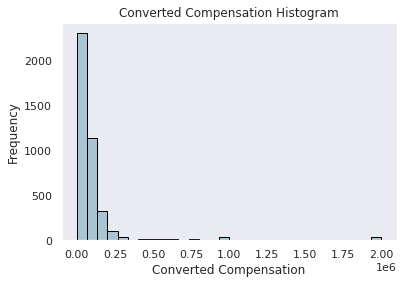

In [87]:
# set the figure size
plt.figure(figsize = [12,6])

fig, ax = plt.subplots()
X_train['ConvertedComp'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
ax.set_title('Converted Compensation Histogram', fontsize=12)
ax.set_xlabel('Converted Compensation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

The above distribution depicts a right skew in the income with lots of 0 values and fewer data coders earning more money. There are also many missing entries in this column. Since, from the point of view of this analysis the 0 entries and the missing entries will be treated similarly, we fill all the missing values with 0.

In [88]:
# determine the number of missing values in the training set
X_train.ConvertedComp.isnull().sum()

2009

In [96]:
# find the country medians
temps = X_train.groupby('Country')

In [97]:
# impute the ConvertedComp missing values with the median of the corresponding country
# save the existing values and the imputed values in a new column

X_train.loc[:,'ImputedComp'] = X_train.loc[:, 'ConvertedComp'].fillna(temps['ConvertedComp'].transform('median'))

In [98]:
# check how many values are still missing
X_train.ImputedComp.isnull().sum()

20

In [100]:
# fill NaN in a specific column
X_train.loc[:,'ImputedComp'].fillna(0)

# drop those values with 0 imputedCompensation
#.drop(df1[df1.ImputedComp == 0.0].index, inplace = True)

# check for success
len(X_train[X_train['ImputedComp'] == 0])

21

### Create bins for numerical columns: ImputedComp

In [124]:
# create the labels
cut_labels = ['<10K', '10K-30K', '30K-50K', '50K-100K', '100K-200K', '>200K']

# define the bins 
m = df1.ImputedComp.max()
cut_bins = [0, 10000, 30000, 50000, 100000, 200000, m]

# create a new column which contains the new labels
df1['Comp_Bins'] = pd.cut(df1['ImputedComp'], bins=cut_bins, labels=cut_labels)

In [126]:
# check for success
df1.Comp_Bins.value_counts()

50K-100K     2445
10K-30K      2086
100K-200K    1665
30K-50K      1292
<10K          761
>200K         430
Name: Comp_Bins, dtype: int64

### Create bins for numerical columns: WorkWeekHrs

In [150]:
# create the labels
cut_labels = ['missing', '<10', '10-20', '20-30', '30-40', '40-50', '>50']

# define the bins 
m = df1.WorkWeekHrs.max()
cut_bins = [NaN, 10, 20, 30, 40, 50, m]

# create a new column which contains the new labels
df1['WorkWeek_Bins'] = pd.cut(df1['WorkWeekHrs'], bins=cut_bins, labels=cut_labels)

NameError: name 'NaN' is not defined

In [147]:
# check for success
df1.WorkWeek_Bins.value_counts()

30-40    3843
40-50    1831
>50       603
<10       280
20-30     272
10-20     138
Name: WorkWeek_Bins, dtype: int64

In [160]:
df1['WorkWeekHrs_Bins'] = df1['WorkWeek_Bins'].astype('object')

In [161]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8679 entries, 0 to 8725
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MainBranch        8652 non-null   object  
 1   ConvertedComp     5785 non-null   float64 
 2   Country           8679 non-null   object  
 3   EdLevel           8537 non-null   object  
 4   Employment        8679 non-null   object  
 5   JobFactors        7516 non-null   object  
 6   JobSat            8679 non-null   int64   
 7   EdImpt            8165 non-null   object  
 8   Learn             7938 non-null   object  
 9   Overtime          7393 non-null   object  
 10  OpSys             8081 non-null   object  
 11  OrgSize           7562 non-null   object  
 12  UndergradMajor    8015 non-null   object  
 13  WorkWeekHrs       6967 non-null   float64 
 14  ImputedComp       8679 non-null   float64 
 15  Comp_Bins         8679 non-null   category
 16  WorkWeek_Bins     6967 n

In [163]:
df1['WorkWeekHrs_Bins'] = df1['WorkWeekHrs_Bins'].fillna("unknown")

In [164]:
# fill NaN in a specific column
df1.WorkWeekHrs_Bins.value_counts()

30-40      3843
40-50      1831
unknown    1712
>50         603
<10         280
20-30       272
10-20       138
Name: WorkWeekHrs_Bins, dtype: int64

## Transform categorical data 

In [82]:
# create a list of categorical features
cat_cols = df.select_dtypes(include=['object']).copy().columns
non_cat = ['ConvertedComp', 'WorkWeekHrs']

In [83]:
# encode the categorical variablesas dummy, drop the first column for each feature
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [84]:
df.shape


(8722, 419)

In [85]:
df.columns

Index(['ConvertedComp', 'WorkWeekHrs',
       'MainBranch_I am a student who is learning to code',
       'MainBranch_I am not primarily a developer, but I write code sometimes as part of my work',
       'MainBranch_I code primarily as a hobby',
       'MainBranch_I used to be a developer by profession, but no longer am',
       'Country_Albania', 'Country_Algeria', 'Country_Andorra',
       'Country_Argentina',
       ...
       'UndergradMajor_A humanities discipline (such as literature, history, philosophy, etc.)',
       'UndergradMajor_A natural science (such as biology, chemistry, physics, etc.)',
       'UndergradMajor_A social science (such as anthropology, psychology, political science, etc.)',
       'UndergradMajor_Another engineering discipline (such as civil, electrical, mechanical, etc.)',
       'UndergradMajor_Computer science, computer engineering, or software engineering',
       'UndergradMajor_Fine arts or performing arts (such as graphic design, music, studio art,

In [86]:
import janitor as jn
X, y = jn.get_features_targets(df, target_columns='JobSat')

ModuleNotFoundError: No module named 'janitor'

## Create a training set and a test set

In [ ]:
# create the 

### Comments: dropping columns

I will build a classification model to predict the level of job satisfaction a developer has. Several of the columns have very high cardinality, and also there are a few redundant columns which can be dropped at this point. Here is a list of columns we can drop:

### Clean Data

Some preliminary processing was already performed on the data. 